In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
from rubik.cube import Cube
from rubik.solve import Solver

## Upload Images

In [12]:
# Upload images 
front_image_path = 'front.jpg'
right_image_path = 'right.jpg'
left_image_path = 'left.jpg'
top_image_path = 'top.jpg'
back_image_path = 'back.jpg'
bottom_image_path = 'bottom.jpg'

front = None
if os.path.exists(front_image_path):
    front = cv2.imread(front_image_path)
    front = cv2.cvtColor(front, cv2.COLOR_BGR2RGB)
    
right = None
if os.path.exists(right_image_path):
    right = cv2.imread(right_image_path)
    right = cv2.cvtColor(right, cv2.COLOR_BGR2RGB)
    
left = None
if os.path.exists(left_image_path):
    left = cv2.imread(left_image_path)
    left = cv2.cvtColor(left, cv2.COLOR_BGR2RGB)
    
top = None
if os.path.exists(top_image_path):
    top = cv2.imread(top_image_path)
    top = cv2.cvtColor(top, cv2.COLOR_BGR2RGB)
    
back = None
if os.path.exists(back_image_path):
    back = cv2.imread(back_image_path)
    back = cv2.cvtColor(back, cv2.COLOR_BGR2RGB)
    
bottom = None
if os.path.exists(bottom_image_path):
    bottom = cv2.imread(bottom_image_path)
    bottom = cv2.cvtColor(bottom, cv2.COLOR_BGR2RGB)
    
face_images = {'top': top, 'left': left, 'front': front, 'right': right, 'back': back, 'bottom': bottom}

<IPython.core.display.Javascript object>


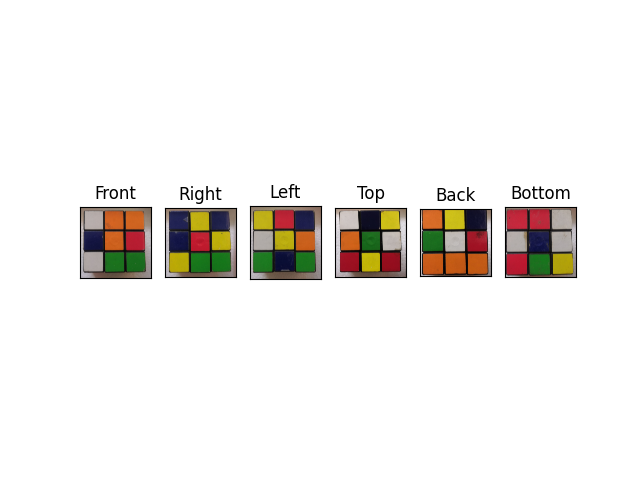

In [13]:
fig, axes = plt.subplots(1, 6)
axes[0].imshow(front)
axes[0].set_title('Front'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(right)
axes[1].set_title('Right'), axes[1].set_xticks([]), axes[1].set_yticks([]);
axes[2].imshow(left)
axes[2].set_title('Left'), axes[2].set_xticks([]), axes[2].set_yticks([]);
axes[3].imshow(top)
axes[3].set_title('Top'), axes[3].set_xticks([]), axes[3].set_yticks([])
axes[4].imshow(back)
axes[4].set_title('Back'), axes[4].set_xticks([]), axes[4].set_yticks([]);
axes[5].imshow(bottom)
axes[5].set_title('Bottom'), axes[5].set_xticks([]), axes[5].set_yticks([]);

In [14]:
def detect_cube_and_crop(image):
    image_with_edges = cv2.Canny(image, 100, 200)
    h, w = image_with_edges.shape
    
    top_left_corner = [0, 0]
    found_top_left_corner = False
    x_values = []
    for y in range(h):
        for x in range(w):
            if not found_top_left_corner and image_with_edges[y][x] > 0:
                top_left_corner = [x, y]
                found_top_left_corner = True
                break
            elif len(x_values) > 0 and x > min(x_values):
                break
            elif image_with_edges[y][x] > 0:
                x_values.append(x)
                break
    top_left_corner[0] = min(x_values)
                
    bottom_left_corner = [top_left_corner[0], 0]
    found_bottom_left_corner = False
    for y in range(h):
        if found_bottom_left_corner:
            break
        for x in range(w):
            if image_with_edges[(h - 1) - y][x] > 0:
                bottom_left_corner[1] = (h - 1) - y
                found_bottom_left_corner = True
                break
                
    height_of_cube = bottom_left_corner[1] - top_left_corner[1]

    cropped_image = np.zeros((height_of_cube, height_of_cube))
    cropped_image = image[top_left_corner[1] : top_left_corner[1] + height_of_cube, top_left_corner[0] : top_left_corner[0] + height_of_cube]
    
    return cropped_image

In [6]:
import matplotlib.pyplot as plt
%matplotlib notebook

Progress: 17%
Progress: 33%
Progress: 50%
Progress: 67%
Progress: 83%
Progress: 100%


<IPython.core.display.Javascript object>


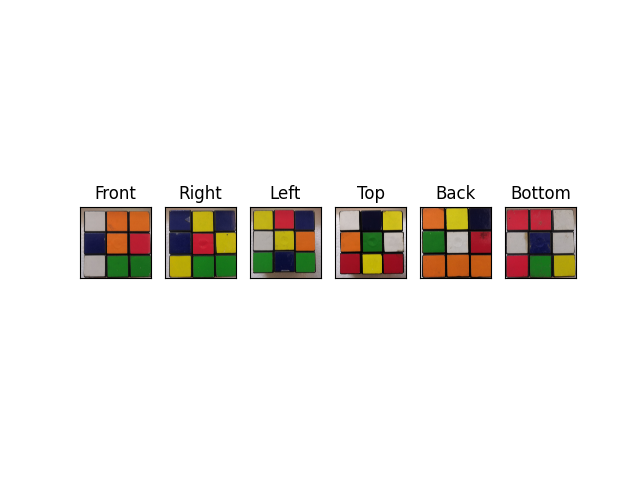

In [15]:
cropped_face_images = {}
i = 0
for k in face_images:
    if face_images[k] is None:
        continue
    cropped_face_images[k] = detect_cube_and_crop(face_images[k])
    i += 1
    print(f"Progress: {round((i / len(face_images)) * 100)}%")

fig, axes = plt.subplots(1, 6)
axes[0].imshow(cropped_face_images['front'])
axes[0].set_title('Front'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(cropped_face_images['right'])
axes[1].set_title('Right'), axes[1].set_xticks([]), axes[1].set_yticks([]);
axes[2].imshow(cropped_face_images['left'])
axes[2].set_title('Left'), axes[2].set_xticks([]), axes[2].set_yticks([]);
axes[3].imshow(cropped_face_images['top'])
axes[3].set_title('Top'), axes[3].set_xticks([]), axes[3].set_yticks([])
axes[4].imshow(cropped_face_images['back'])
axes[4].set_title('Back'), axes[4].set_xticks([]), axes[4].set_yticks([]);
axes[5].imshow(cropped_face_images['bottom'])
axes[5].set_title('Bottom'), axes[5].set_xticks([]), axes[5].set_yticks([]);

In [16]:
def detect_color(rgb_pixel):
    colors = {
        "green": [71, 135, 79],
        "blue": [4, 60, 135],
        "red": [182, 40, 43],
        "yellow": [225, 195, 64],
        "white": [224, 212, 202],
        "orange": [209, 114, 16]
    }
    score = {"green": 0, "blue": 0, "red": 0, "yellow": 0, "white": 0, "orange": 0}
    
    for k, v in colors.items():
        color_score = 0
        
        for i in range(3):
            color_score += abs(v[i] - rgb_pixel[i])
        score[k] = color_score
    
    return min(score, key=score.get)

def calculate_most_common_color(colors):
    color_dict = {}
    for color in set(colors):
        color_dict[color] = colors.count(color)
    return max(color_dict, key=color_dict.get)
        
def extract_color_info_from_cube_face(cropped_image):    
    h, w, c = cropped_image.shape
    patch_height = np.ceil(h / 3).astype(int)
    patch_width = np.ceil(w / 3).astype(int)
    
    face_info = [[None, None, None], [None, None, None], [None, None, None]]
    i = 0
    for x in range(0, w, patch_width):
        j = 0
        for y in range(0, h, patch_height):

            # Sample 4 pixels for colors and vote
            color_vote = []
            quarter_patch_height = np.ceil(patch_height / 4).astype(int)
            quarter_patch_width = np.ceil(patch_width / 4).astype(int)
            
            pixels_to_sample = [
                cropped_image[y + quarter_patch_height][x + quarter_patch_width],
                cropped_image[y + (patch_height - quarter_patch_height)][x + quarter_patch_width],
                cropped_image[y + quarter_patch_height][x + (patch_width - quarter_patch_width)],
                cropped_image[y + (patch_height - quarter_patch_height)][x + (patch_width - quarter_patch_width)]
            ]
            
            for pixel in pixels_to_sample:
                color_vote.append(detect_color(pixel))

            face_info[j][i] = calculate_most_common_color(color_vote)
            j += 1
        i += 1

    return face_info

In [17]:
faces = {'top': None, 'left': None, 'front': None, 'right': None, 'back': None, 'bottom': None}
for k in cropped_face_images:
    if cropped_face_images[k] is None:
        continue
    faces[k] = extract_color_info_from_cube_face(cropped_face_images[k])

In [18]:
def verify_cube_string_is_valid(cube_string):
    count = {"G": 0, "B": 0, "R": 0, "Y": 0, "W": 0, "O": 0}

    for c in cube_string:
        count[c] += 1
    
    for k in count:
        if count[k] != 9:
            raise Exception(f"Invalid cube string: {cube_string}")
            
    return cube_string

def generate_cube_string(faces):
    cube_string = ''
    
    face = faces['top']
    for i in range(3):
        for j in range(3):
            cube_string += face[i][j][0].capitalize()
    
    order = ['left', 'front', 'right', 'back']
    for i in range(3):
        for o in order:
            face = faces[o]
            for j in range(3):
                cube_string += face[i][j][0].capitalize()
            
    face = faces['bottom']
    for i in range(3):
        for j in range(3):
            cube_string += face[i][j][0].capitalize()
    
    return verify_cube_string_is_valid(cube_string)

def solve_cube(cube):
    c = Cube(cube)
    print(f"Cube: \n{c}\n\n")
    solver = Solver(c)
    solver.solve()
    return solver.moves

In [20]:
cube = generate_cube_string(faces)

Exception: Invalid cube string: WBYOGWRORYRBWOOBOBOYBWOOBORBROGWRGBBWGGOGGOOORRWWBWRGO

In [19]:
cube = generate_cube_string(faces)
print(f"Solution: \n\n{solve_cube(cube)}\n")
print("For notation reference, visit https://ruwix.com/the-rubiks-cube/notation/")

Exception: Invalid cube string: WBYOGWRORYRBWOOBOBOYBWOOBORBROGWRGBBWGGOGGOOORRWWBWRGO

In [21]:
c = Cube('WBYOGWRORYRBWOOBOBOYBWOOBORBROGWRGBBWGGOGGOOORRWWBWRGO')
print(c)

    WBY
    OGW
    ROR
YRB WOO BOB OYB
WOO BOR BRO GWR
GBB WGG OGG OOO
    RRW
    WBW
    RGO


In [ ]:
#colors to adjust
#Yellow-Orange
#Blue-Green